In [1]:
from typing import List
import numpy as np


class Visitor:
    def __str__(self):
        return self.__class__.__name__

    def visit(self):
        raise NotImplementedError


class ODEBase(object):
    def __init__(self):
        self.system = None
        self.jac = None
        self.solution = None

    def accept(self, visitor):
        return visitor.visit(self)

    def draw_direction_field(self):
        raise NotImplementedError


class ODEIntegrator:
    def __init__(self):
        self.y0 = []
        self.t0, self.t1 = 0, 0
        self.dt = 0.1

    def set_initial(self, y0: List[object]):
        self.y0 = y0
        return self

    def set_time(self, t0, t1):
        self.t0, self.t1 = t0, t1
        return self

    def set_dt(self, dt):
        self.dt = dt
        return self

    def integrate(self, ode_sys: ODEBase):
        raise NotImplementedError


class Euler(ODEIntegrator):
    def __init__(self):
        ODEIntegrator.__init__(self)

    def __str__(self):
        return self.__class__.__name__

    def integrate(self, ode_sys: ODEBase):
        u = [[_] for _ in self.y0]
        t = self.t0
        while t < self.t1:
            t = t + self.dt
            u0 = [_[-1] for _ in u]
            u1 = ode_sys.system(u0)
            for v, v0, _ in zip(u1, u0, u):
                _.append(v0+self.dt*v)
        return np.array(u)


class ODESolver(Visitor):
    def __init__(self, integrator: ODEIntegrator):
        self.integrator = integrator

    def visit(self, ode_sys: ODEBase):
        ode_sys.solution = self.integrator.integrate(ode_sys)

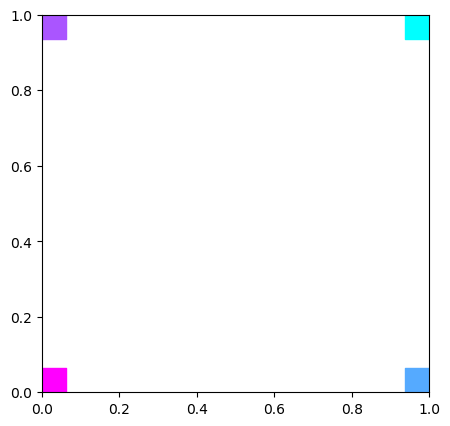

In [2]:
import CMGDB
import matplotlib

def f(x):
    return [x[0]/(2-x[0]), x[1]/(2-x[1])]


def g(x):
    return [2.5*x[0]*(1-x[0])]


def F(rect):
    return CMGDB.BoxMap(f, rect, padding=False)


def G(rect):
    return CMGDB.BoxMap(g, rect, padding=False)


class Eqn(ODEBase):
    def __init__(self):
        ODEBase.__init__(self)
        self.system = self.set_system()

    def set_system(self):
        def syseq(xy):
            x, y = xy[0], xy[1]
            return [x*(1-x), y*(1-y)]
        return syseq


def FF(rect):
    x0_min = rect[0]
    x1_min = rect[1]
    x0_max = rect[2]
    x1_max = rect[3]
    solver.set_initial([x0_min, x1_min])
    ode_solver = ODESolver(solver)
    eqn.accept(ode_solver)
    sol = eqn.solution
    y1 = [sol[0][-1], sol[1][-1]]
    solver.set_initial([x0_max, x1_min])
    ode_solver = ODESolver(solver)
    eqn.accept(ode_solver)
    sol = eqn.solution
    y2 = [sol[0][-1], sol[1][-1]]
    solver.set_initial([x0_min, x1_max])
    ode_solver = ODESolver(solver)
    eqn.accept(ode_solver)
    sol = eqn.solution
    y3 = [sol[0][-1], sol[1][-1]]
    solver.set_initial([x0_max, x1_max])
    ode_solver = ODESolver(solver)
    eqn.accept(ode_solver)
    sol = eqn.solution
    y4 = [sol[0][-1], sol[1][-1]]
    y0_min = min([y1[0], y2[0], y3[0], y4[0]])
    y0_max = max([y1[0], y2[0], y3[0], y4[0]])
    y1_min = min([y1[1], y2[1], y3[1], y4[1]])
    y1_max = max([y1[1], y2[1], y3[1], y4[1]])
    return [y0_min, y1_min, y0_max, y1_max]


class Eqna(ODEBase):
    def __init__(self, a):
        ODEBase.__init__(self)
        self.a = a
        self.system = self.set_system()

    def set_system(self):
        def syseq(xy):
            x, y = xy[0], xy[1]
            a, sq = self.a, x*x+y*y
            return [a*x-y-x*sq, x+a*y-y*sq]
        return syseq


subdiv_min = 8
subdiv_max = 16
subdiv_init = 8
subdiv_limit = 10000
lower_bounds = [0, 0]  # lower_bounds = [-5, 5]
upper_bounds = [1, 1]  # upper_bounds = [5, 5]

eqn = Eqn()
solver = Euler()
solver.set_time(0, 1)
solver.set_dt(0.1)

model = CMGDB.Model(subdiv_min, subdiv_max, subdiv_init, subdiv_limit,
                    lower_bounds, upper_bounds, FF)
morse_graph, map_graph = CMGDB.ComputeMorseGraph(model)
CMGDB.PlotMorseGraph(morse_graph, cmap=matplotlib.cm.cool).render(view=True)
CMGDB.PlotMorseSets(morse_graph, cmap=matplotlib.cm.cool, fig_w=5, fig_h=5)
